## Importing necessary libraries

In [2]:
# Data manipulation & handling libraries
import pandas as pd 
import numpy as np 

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# VIF library
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model selection libraries
from sklearn.model_selection import train_test_split,cross_val_score

# Model evaluation libraries
from sklearn.metrics import r2_score,mean_squared_error

# Machine learning libraries
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Hyperparameter tuning parameters
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Clustering
from sklearn.cluster import KMeans

# Feature importance library
from sklearn.feature_selection import RFE

# Learning curve analysis
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
df = pd.read_excel('Capstone Project.xlsx')

In [3]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
df.tail()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06
1029,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,7,52.61


Problem statement: Build a predictive model to understand the strength of concrete based on the ingredients used and the age.

## Exploratory data analysis

In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### Analysis from describe function:
    1.There are no missing values in the dataset
    2.There is a chance that cement,slag,ash could be platykurtic since the standard deviation is high
    3.Cement is positively skewed since mean is greater than median
    4.Slag,ash,age is highly positively skewed which gives a hint that there could be outliers in slag
    5.Water,coarseagg could be normally distributed since mean and median are close and standard deviation is small when compared to mean which means either it could be leptokurtic or mesokurtic
    6.Superplasticisers,fineagg,strength could be normally distributed and there is a chance there are outliers in the upper wisker region

### Custom descriptive statistics function

In [6]:
def custom_summary(dataframe):
    from collections import OrderedDict
    result = []
    
    for col in list(dataframe.columns):
        if(dataframe[col].dtype != object):
            stats = OrderedDict({'column_name':col,
                                'count':dataframe[col].count(),
                                 'no. of non-null values':dataframe[col].notnull().count(),
                                 'data_type':dataframe[col].dtype,
                                 'minimum':dataframe[col].min(),
                                 'Q1':dataframe[col].quantile(0.25),
                                 'mean':dataframe[col].mean(),
                                 'Q2':dataframe[col].quantile(0.5),
                                'Q3':dataframe[col].quantile(0.75),
                                 'maximum':dataframe[col].max(),
                                 'std dev':dataframe[col].std(),
                                 'kurtosis':dataframe[col].kurt(),
                                 'skewness':dataframe[col].skew(),
                                 'IQR':dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
                                }) 
            result.append(stats)
            # labels for skewness
            if dataframe[col].skew() <= -1:
                sklabel = 'Highly Negatively Skewed'
            elif -1 <= dataframe[col].skew() < -0.5:
                sklabel = 'Moderately Negatively Skewed'
            elif -0.5 <= dataframe[col].skew() < 0:
                sklabel = 'Fairly Symmetric(negative)'
            elif 0 <= dataframe[col].skew() < 0.5:
                sklabel = 'Fairly Symmetric(positive)'
            elif 0.5 <= dataframe[col].skew() < 1:
                sklabel = 'Moderately Positively Skewed'
            elif dataframe[col].skew() > 1:
                sklabel = 'Highly Positively Skewed'
            else:
                sklabel = 'Error'
            stats['Skewness Comments'] = sklabel 
        
            # labels for outliers
            upper_limit = stats['Q3']+ 1.5*stats['IQR']
            lower_limit = stats['Q1']- 1.5*stats['IQR']
            if len([x for x in dataframe[col] if x < lower_limit or x > upper_limit]) > 0:
               outlier_label = 'Has Outliers'
            else:
               outlier_label = 'No Outliers'
        
            stats['Outliers Comments'] = outlier_label
            stats['No.of outliers'] = len((dataframe.loc[(dataframe[col]< lower_limit) | (dataframe[col]> upper_limit)]))
           
        resultdf = pd.DataFrame(data = result)
    return resultdf.T
        

In [7]:
custom_summary(dataframe=df )

,0,1,2,3,4,5,6,7,8
column_name,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030,1030,1030,1030,1030,1030,1030,1030,1030
no. of non-null values,1030,1030,1030,1030,1030,1030,1030,1030,1030
data_type,float64,float64,float64,float64,float64,float64,float64,int64,float64
minimum,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1.0,2.33
Q1,192.375,0.0,0.0,164.9,0.0,932.0,730.95,7.0,23.71
mean,281.167864,73.895825,54.18835,181.567282,6.20466,972.918932,773.580485,45.662136,35.817961
Q2,272.9,22.0,0.0,185.0,6.4,968.0,779.5,28.0,34.445
Q3,350.0,142.95,118.3,192.0,10.2,1029.4,824.0,56.0,46.135
maximum,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365.0,82.6


### Analysis:
1. Slag,water,superplastic,fineagg,age and strength have outliers
2. Age is the only feature which is highly positively skewed

## Outlier detection and treatment plots

### Building outlier treatment function

In [8]:
def outlier_treatment(df,col,method = 'quartile',strategy = 'median'):
    col_data = df[col]
    # Using IQR to detect outliers
    if method == 'quartile':
        Q1,Q3 = col_data.quantile(0.25),col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5*IQR)
        upper_range = Q3 + (1.5*IQR)
    elif method == 'std':
        mean = col_data.mean()
        std = col_data.std()
        lower_range = mean - (2*std)
        upper_range = mean + (2*stAd)
    else:
        print('Pass the correct method')
    
    # Printing all the outliers
    outliers = df.loc[(col_data < lower_range) | (col_data > upper_range),col]
    outlier_density = round(len(outliers)/len(df),2)
    
    if(len(outliers)==0):
        print(f'Feature {col} does not have any outliers\n')
    else:
        print(f'Feature {col} has outliers\n')
        print(f'Total number of outliers in {col} are {len(outliers)}\n')
        print(f'Outlier percentage in {col} is {outlier_density}\n')
        display(df[(col_data < lower_range) | (col_data > upper_range)]) 
    
    # Treating outliers
    if strategy == 'median':
         df.loc[(col_data < lower_range) | (col_data > upper_range),col] = col_data.median()
            #df.loc[(col_data < lower_range),col] = lower_range
            #df.loc[(col_data > upper_range),col] = upper_range

    elif strategy == 'mean':
         df.loc[(col_data < lower_range) | (col_data > upper_range),col] = col_data.mean()
    else:
        print('Pass the correct strategy')
        
    return df

In [9]:
def odt_plots(df,col):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,8))
    
    # Descriptive statistics box plot
    sns.boxplot(df[col],ax=ax1)
    ax1.set_title(col+' Boxplot')
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('Values')
    
    # Plotting histogram with outliers
    sns.distplot(df[col],ax=ax2,fit=sci.norm)
    ax2.set_title(col+' Histogram with outliers')
    ax2.set_xlabel('Density')
    ax2.set_ylabel('Values')
    
    # Treating outliers
    df_out = outlier_treatment(df,col)
    
    # Plotting histogram without outliers
    sns.distplot(df_out[col],ax=ax3,fit=sci.norm)
    ax3.set_title(col+' Histogram without outliers')
    ax3.set_xlabel('Density')
    ax3.set_ylabel('Values') 
    plt.show()

Feature cement does not have any outliers



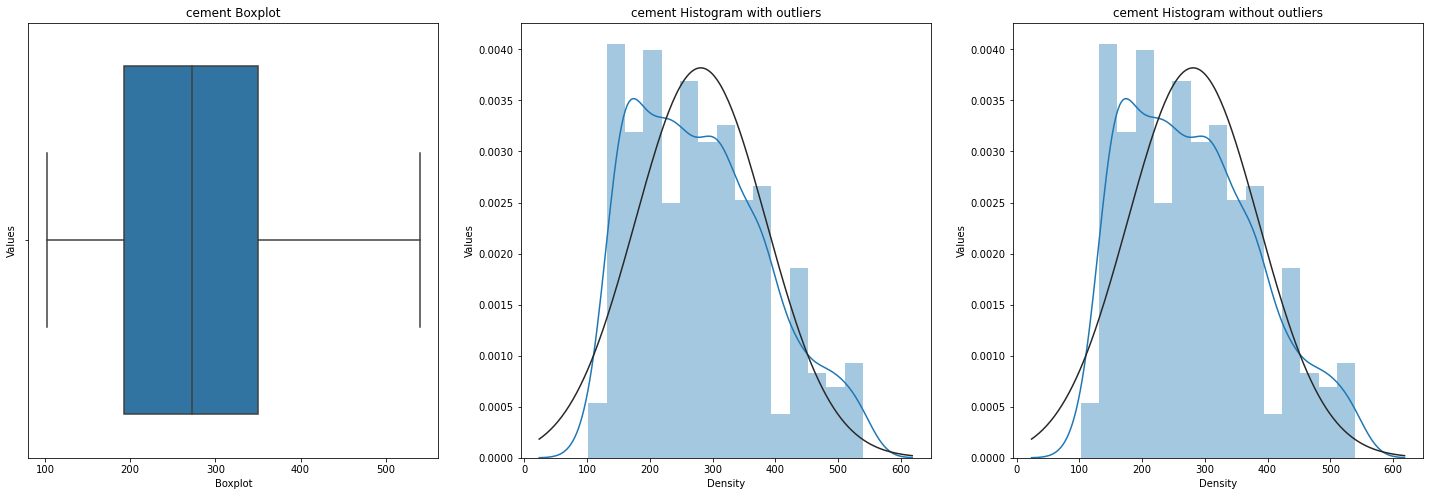

Feature slag has outliers

Total number of outliers in slag are 2

Outlier percentage in slag is 0.0



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


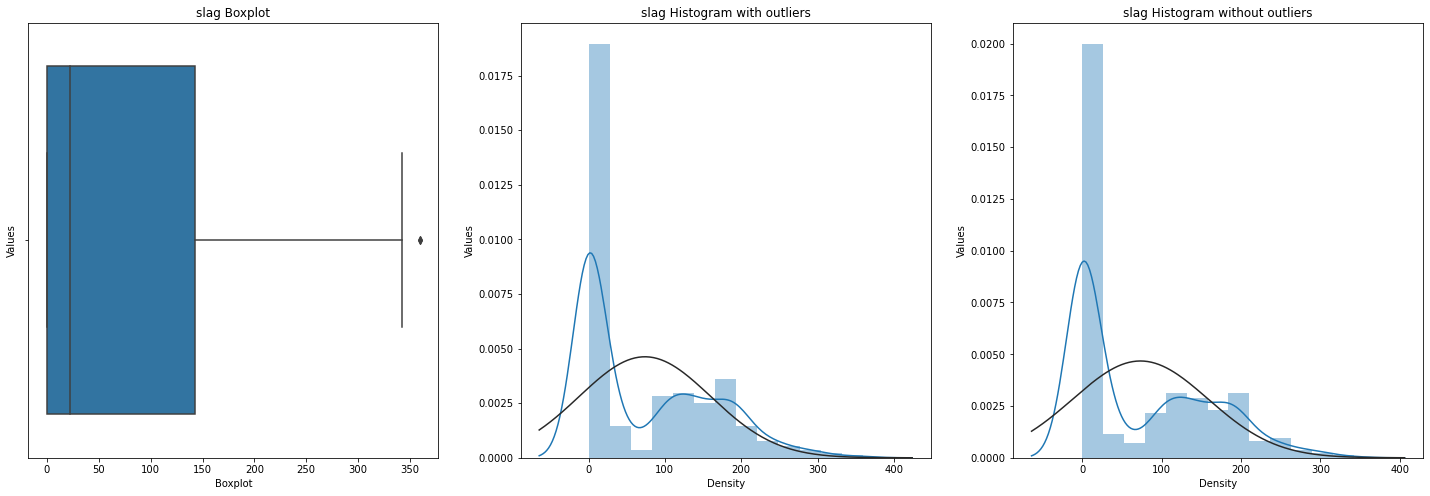

Feature ash does not have any outliers



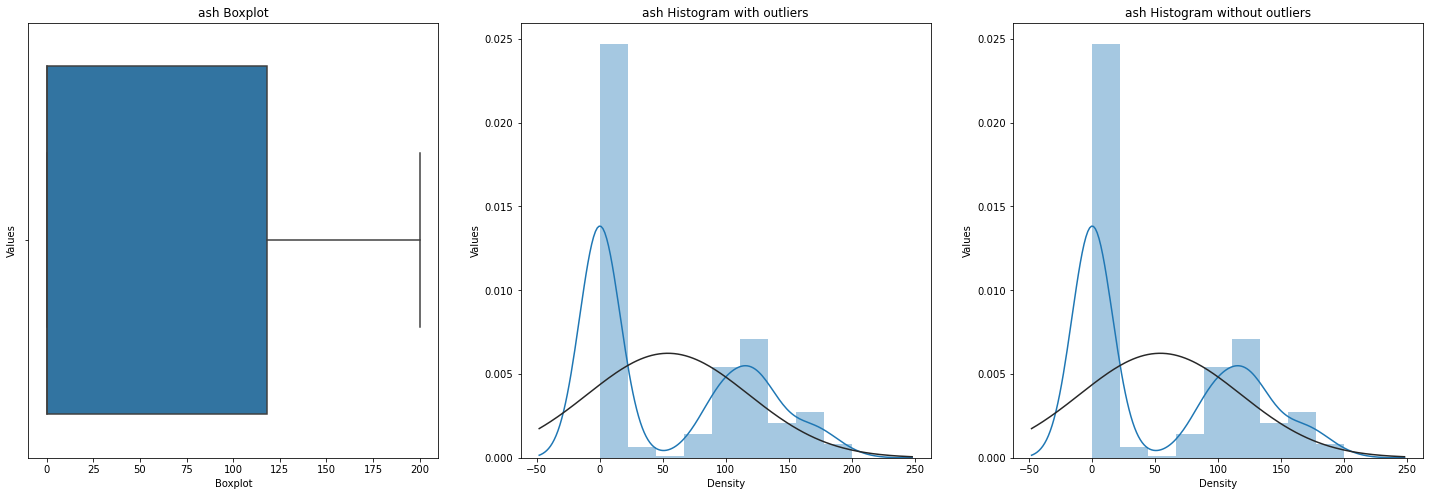

Feature water has outliers

Total number of outliers in water are 9

Outlier percentage in water is 0.01



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


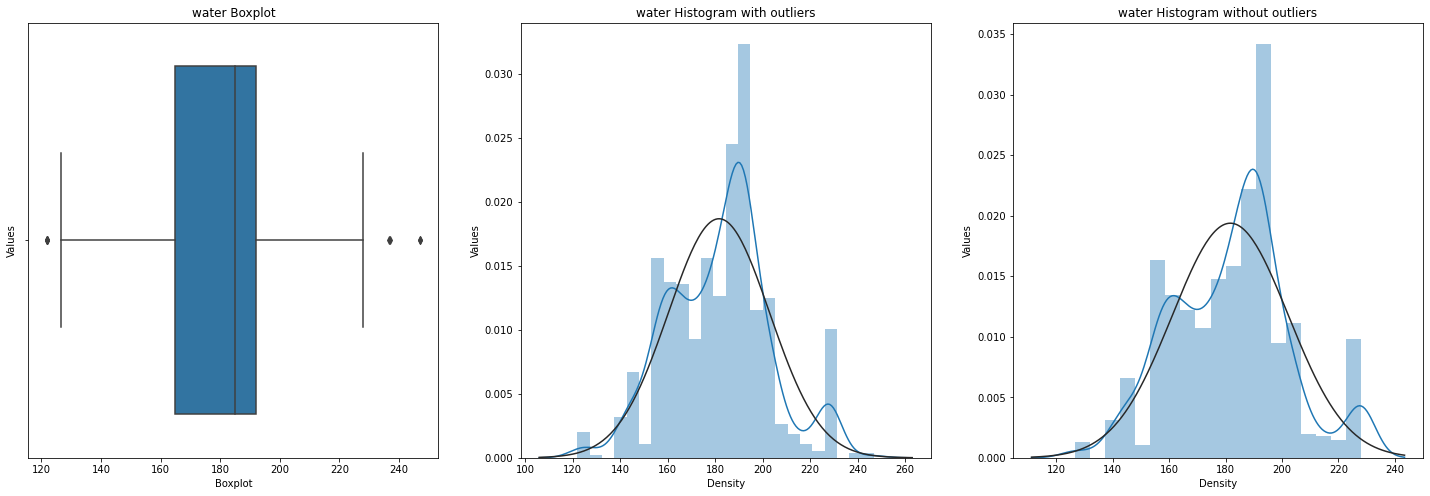

Feature superplastic has outliers

Total number of outliers in superplastic are 10

Outlier percentage in superplastic is 0.01



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


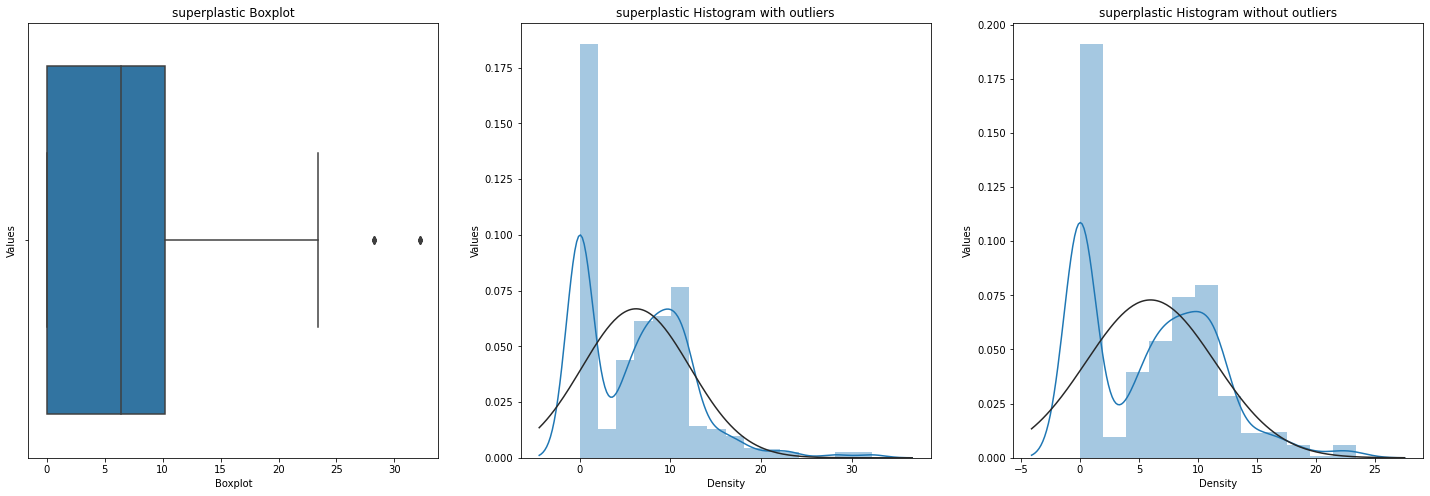

Feature coarseagg does not have any outliers



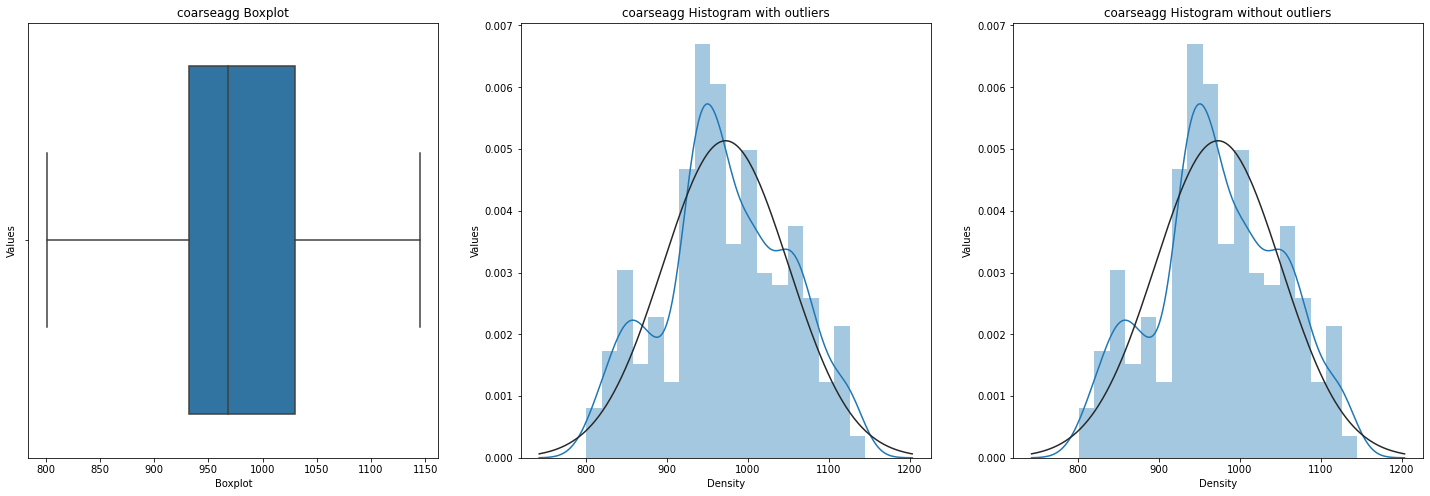

Feature fineagg has outliers

Total number of outliers in fineagg are 5

Outlier percentage in fineagg is 0.0



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


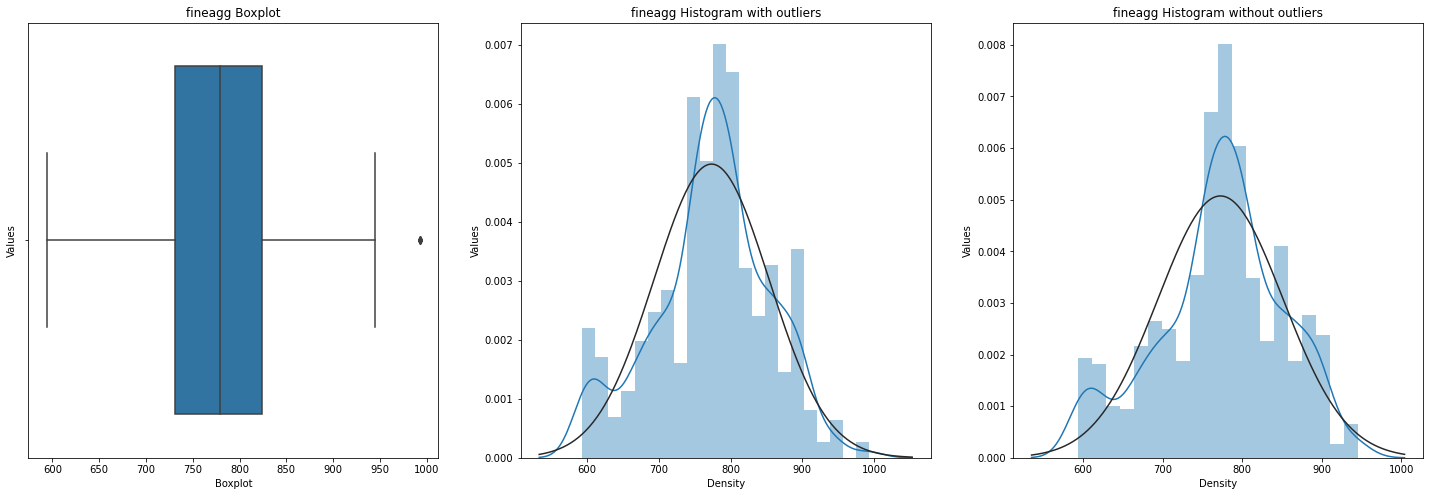

Feature age has outliers

Total number of outliers in age are 59

Outlier percentage in age is 0.06



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


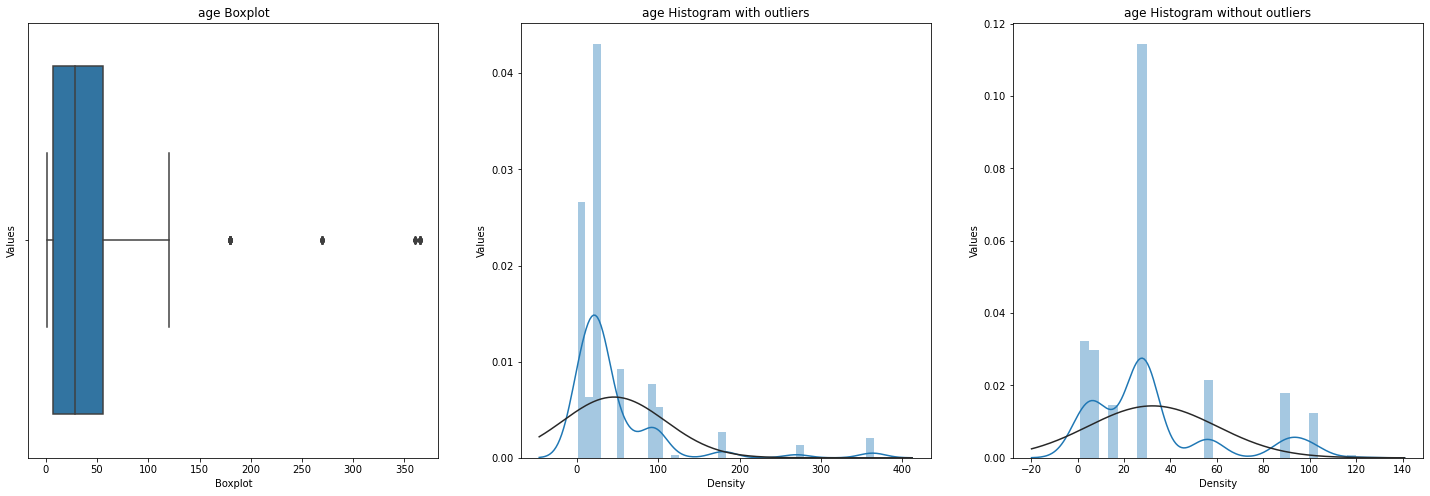

Feature strength has outliers

Total number of outliers in strength are 4

Outlier percentage in strength is 0.0



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


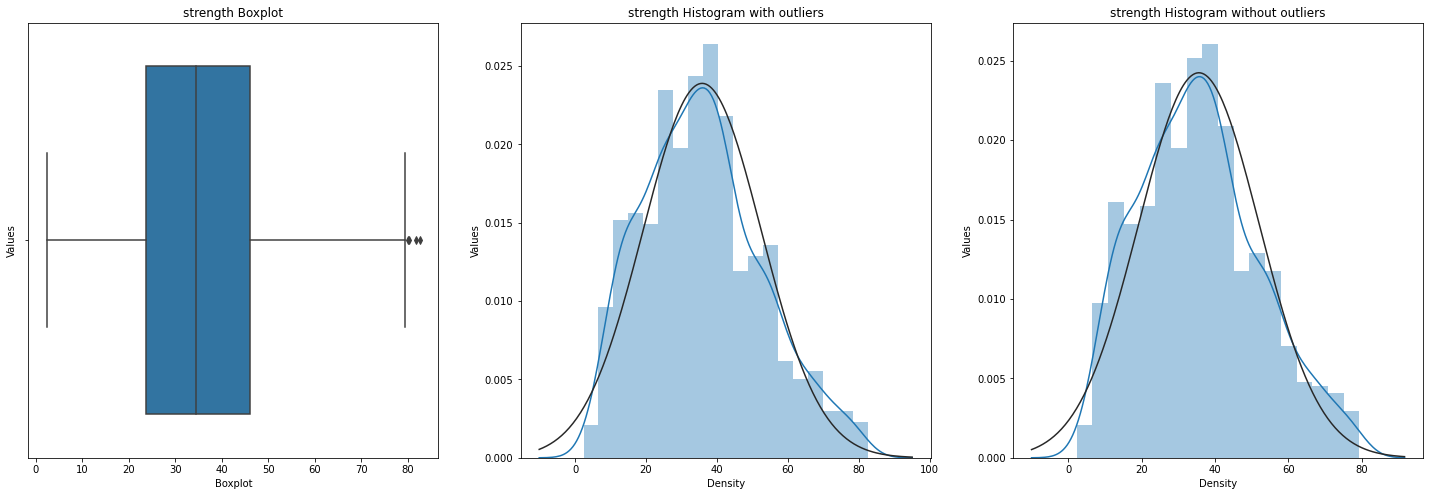

In [10]:
for i in df.columns:
    odt_plots(df,i)

## Multivariate analysis using regression

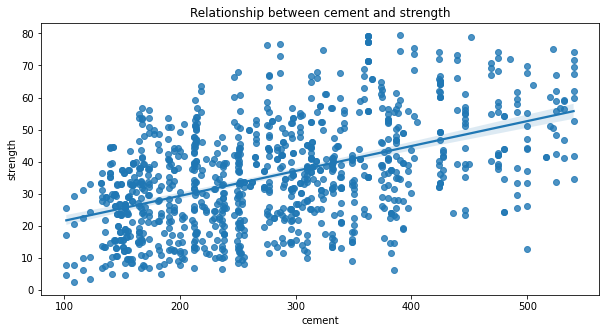

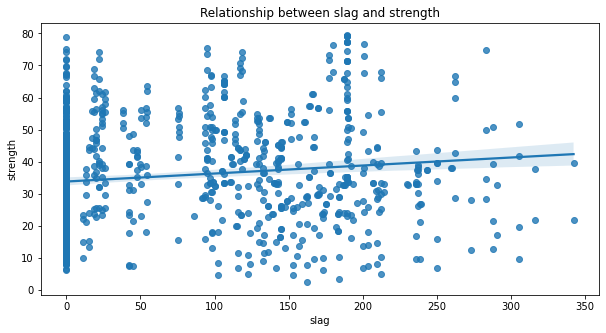

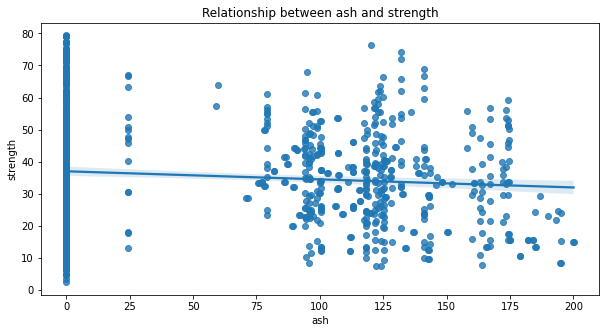

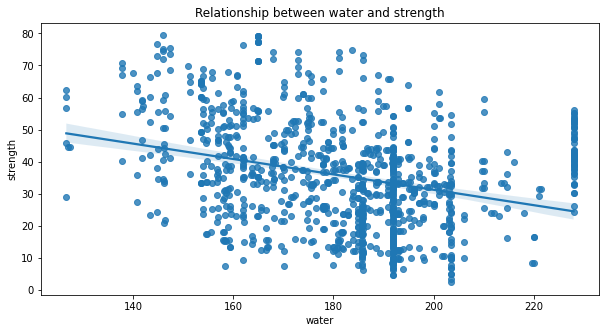

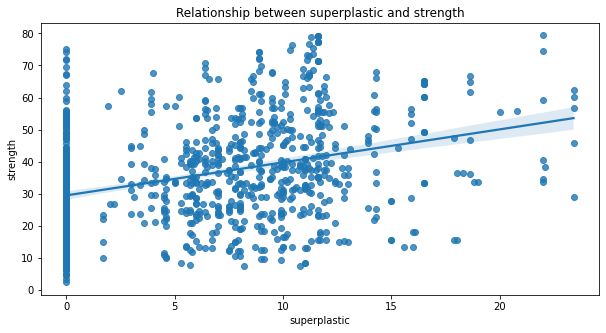

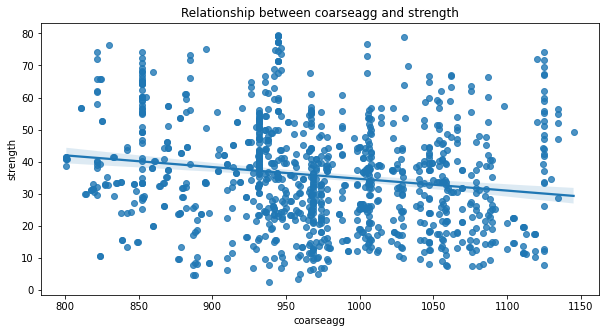

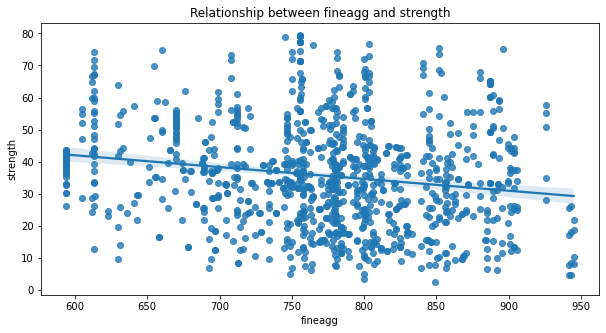

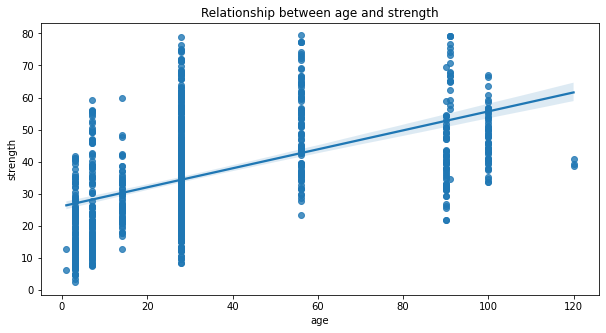

In [11]:
for col in df.columns:
    if col!= 'strength':
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x=df[col],y=df['strength'],ax=ax1).set_title(f'Relationship between {col} and strength')

#### Analysis:
1. Strength and cement are highly positively correlated
2. Strength and slag are slightly positively correlated
3. Strength and ash are slightly negatively correlated
4. Strength and water are highly negatively correlated
5. Strength and superplastic are highly positively correlated
6. Strength and coarseagg are slightly negatively correlated
7. Strength and fineagg are slightly negatively correlated
8. Strength and age are highly positively correlated

## Multicollinearity test

### Stage 1: Correlation heatmap

<AxesSubplot:>

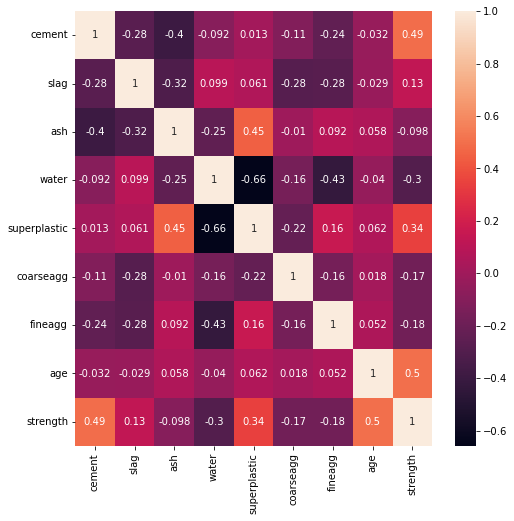

In [12]:
corr = df.corr()
plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot=True)

### Analysis:
1. Cement and ash has 40% correlation
2. Superplastic and ash has 45% correlation
3. Superplastic and water has 66% correlation
4. Fineagg and water has 43% correlation
5. Ash and slag has 32% correlation
-Conclusion: Many features have correlation greater than 30%. So we can conclude collinearity exists as stage 1 results

## Stage 2: Variance Inflation Factor(VIF)
    - Formula for VIF is : 1/(1-r2)
    - Steps:
        1. Regress every independent variable with each other and find the R square
        2. Find out the VIF using the above formula
        3. If VIF is more than 5 then we can say multicollinearity exists(threshold can be 5 or 10)

In [13]:
def VIF(features):
    vif = pd.DataFrame()
    vif['VIF Score'] = [variance_inflation_factor(features.values,i) for i in range(features.shape[1])]
    vif['Features']  = features.columns
    vif.sort_values(by=['VIF Score'],ascending= False,inplace=True)
    return vif

In [14]:
VIF(df.drop('strength',axis=1))

,VIF Score,Features
5,86.938582,coarseagg
3,81.963087,water
6,68.664404,fineagg
0,14.291158,cement
4,5.724145,superplastic
2,4.415840,ash
1,3.342314,slag
7,2.368372,age


### Analysis:
    Many features have VIF more than 5 so we can conclude multicollinearity exists as Stage 2 results

### Correlation with target feature

In [15]:
def cwt(data,t_col):
    independent_variables = data.drop(t_col,axis = 1).columns
    corr_result =[]
    for col in independent_variables:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variables,corr_result],index=['Independent_variables','Correlation']).T
    return result.sort_values(by= ['Correlation'])

In [16]:
cwt(df,'strength')

,Independent_variables,Correlation
3,water,-0.300043
6,fineagg,-0.176113
5,coarseagg,-0.173234
2,ash,-0.097973
1,slag,0.129561
4,superplastic,0.342633
0,cement,0.493518
7,age,0.499711


### Analysis 
    1. Age and cement has 49% correlation with strength(highly correlated)
    2. Superplastic has 34% correlation with strength
    3. Water has -30% correlation with strength i.e., it is negatively correlated

## Applying PCA to treat multicollinearity

In [17]:
def pca_func(X):
    n_comp = len(X.columns)
    
    # Feature scaling
    X = StandardScaler().fit_transform(X)
    
    # Applying PCA
    for i in range(1,n_comp):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if(evr[i-1]>0.9):
            pcs = i
            break
            
    print('Explained variance ratio after PCA is:',evr)
#creating dataframe using principal components
    col = []
    for j in range(1,pcs+1):
        col.append('PC_'+str(j))
    pca_df = pd.DataFrame(data=p_comp,columns=col)   
    return pca_df

In [18]:
pca_df = pca_func(df.drop('strength',axis=1))

Explained variance ratio after PCA is: [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [19]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228


### Joining PCA feature with target feature

In [20]:
transformed_df = pca_df.join(df['strength'])

In [21]:
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


## Model Building
    - Train test split
    - Cross validation
    - Hyperparameter tuning

### Train test split

In [22]:
def train_and_test_split(data,y,test_size=0.3,random_state=10):
    X = data.drop(y,1)
    return train_test_split(X,data[y],test_size=test_size,random_state=random_state)

In [23]:
def model_builder(model_name,estimator,data,t_col):
    X_train,X_test,y_train,y_test = train_and_test_split(data,t_col)
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    r2score = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    return model_name,r2score,rmse

In [24]:
model_builder('Linear regression',LinearRegression(),transformed_df,'strength')

('Linear regression', 0.6772585559335703, 9.107669400753677)

### Building multiple models

In [25]:
def multiple_models(data,t_col):
    col = ['Model_Name','R2 Score','RMSE']
    result = pd.DataFrame(columns=col)
    
    # Adding values to result dataframe
    result.loc[len(result)] = model_builder('Linear regression',LinearRegression(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Lasso regression',Lasso(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Ridge regression',Ridge(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Decision Tree regressor',DecisionTreeRegressor(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Support Vector regressor',SVR(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('K Neighbors regressor',KNeighborsRegressor(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Random Forest regressor',RandomForestRegressor(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Adaboost regressor',AdaBoostRegressor(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('Gradient Boost regressor',GradientBoostingRegressor(),transformed_df,'strength')
    result.loc[len(result)] = model_builder('XGBoost regressor',XGBRegressor(),transformed_df,'strength')
    
    return result.sort_values(by=['R2 Score'],ascending=False,ignore_index=True)
    

In [26]:
multiple_models(transformed_df,'strength')

,Model_Name,R2 Score,RMSE
0,XGBoost regressor,0.863192,5.929739
1,Random Forest regressor,0.852921,6.148293
2,Gradient Boost regressor,0.825566,6.695699
3,Decision Tree regressor,0.789171,7.361131
4,Adaboost regressor,0.738839,8.192840
5,K Neighbors regressor,0.735061,8.251873
6,Support Vector regressor,0.707881,8.664832
7,Linear regression,0.677259,9.107669
8,Ridge regression,0.677174,9.108865
9,Lasso regression,0.658662,9.366386


### The top 5 models in the dataset are:
     1. XGBoost
     2. Random Forest
     3. Gradient Boost
     4. Decision Tree
     5. Adaboost

### Cross Validation

In [27]:
def kfold_cv(data,t_col,cv=10):
    model_names = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),SVR(),KNeighborsRegressor(),
                   RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
    scores = ['Score_LR','Score_LS','Score_RD','Score_DTR','Score_SVR','Score_KNR','Score_RFR',
             'Score_ABR','Score_GBR','Score_XGBR']
    
    for model,i in zip(model_names,range(len(scores))):
        scores[i] = (cross_val_score(estimator=model,X=data.drop(t_col,1),y=data[t_col],cv=cv))
    
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        model_name = type(model_names[i]).__name__
        temp = [model_name,score_mean,score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(result,columns=['Model Name','R2 Score','Score Std Deviation'])
    return result_df.sort_values(by=['R2 Score'],ascending=False,ignore_index=True)

In [28]:
kfold_cv(transformed_df,'strength')

,Model Name,R2 Score,Score Std Deviation
0,XGBRegressor,0.873262,0.036061
1,RandomForestRegressor,0.866562,0.031721
2,GradientBoostingRegressor,0.828944,0.050156
3,KNeighborsRegressor,0.768169,0.055962
4,DecisionTreeRegressor,0.760743,0.052415
5,AdaBoostRegressor,0.731475,0.043843
6,SVR,0.703117,0.042765
7,Ridge,0.663935,0.059437
8,LinearRegression,0.663928,0.059476
9,Lasso,0.649837,0.049887


### The top 5 models in the dataset are:
    1. XGBoost
    2. Random Forest
    3. Gradient Boost
    4. Decision Tree
    5. Adaboost

### Hyperparameter tuning

In [29]:
def tuning(X,y,cv=10):
    # Creating the parameter grid
    param_las = {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,
                          60,70,80,90,100,200,300,400,500]}
    param_rds = {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,
                          60,70,80,90,100,200,300,400,500]} 
    param_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    param_dtr = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                'max_features':['auto', 'sqrt', 'log2']}
    param_adb = {'learning_rate':[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_gboost = {'alpha':[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_xgb = {'alpha':[0.1,0.3,0.5,0.7,0.9,1],'gamma':[0,10,20,30,40,50,60,70,80,90,100],
                'eta':[0.01,0.1,0.2]}
    param_rf = {'n_estimators':[50,100,150,200,250,300],
               'criterion':['squared_error', 'absolute_error', 'poisson']}
    
    # Hyperparameter tuning
    tune_las = RandomizedSearchCV(Lasso(),param_las,cv=cv)
    tune_rds = RandomizedSearchCV(Ridge(),param_rds,cv=cv)
    tune_knn = RandomizedSearchCV(KNeighborsRegressor(),param_knn,cv=cv)  
    tune_dtr = RandomizedSearchCV(DecisionTreeRegressor(),param_dtr,cv=cv)    
    tune_adb = RandomizedSearchCV(AdaBoostRegressor(),param_adb,cv=cv)    
    tune_gboost = RandomizedSearchCV(GradientBoostingRegressor(),param_gboost,cv=cv)    
    tune_xgb = RandomizedSearchCV(XGBRegressor(),param_xgb,cv=cv)    
    tune_rf = RandomizedSearchCV(RandomForestRegressor(),param_rf,cv=cv) 
    
    # Model fitting
    tune_models = [tune_las,tune_rds,tune_knn,tune_dtr,tune_adb,tune_gboost,tune_xgb,tune_rf]
    models = ['Lasso','Ridge','KNN','DTR','ADB','GBoost','XGB','RF']
    for i in range(len(tune_models)):
        tune_models[i].fit(X,y)
        
    for i in range(len(tune_models)):
        print('Model: ',models[i])
        print('Best parameters: ',tune_models[i].best_params_)

In [30]:
tuning(transformed_df.drop('strength',axis=1),transformed_df['strength'])

Model:  Lasso
Best parameters:  {'alpha': 1e-05}
Model:  Ridge
Best parameters:  {'alpha': 7}
Model:  KNN
Best parameters:  {'n_neighbors': 7}
Model:  DTR
Best parameters:  {'max_features': 'auto', 'criterion': 'friedman_mse'}
Model:  ADB
Best parameters:  {'learning_rate': 0.8}
Model:  GBoost
Best parameters:  {'alpha': 0.4}
Model:  XGB
Best parameters:  {'gamma': 30, 'eta': 0.2, 'alpha': 0.7}
Model:  RF
Best parameters:  {'n_estimators': 200, 'criterion': 'squared_error'}


In [31]:
def CV_post_hpt(X,y,cv=10):
    score_lr = cross_val_score(LinearRegression(),X,y,cv=cv)
    score_las = cross_val_score(Lasso(alpha=1e-5),X,y,cv=cv)
    score_rd = cross_val_score(Ridge(alpha=2),X,y,cv=cv)
    score_knn = cross_val_score(KNeighborsRegressor(n_neighbors=5),X,y,cv=cv)
    score_dtr = cross_val_score(DecisionTreeRegressor(criterion='friedman_mse',max_features='auto'),X,y,cv=cv)
    score_svr = cross_val_score(SVR(),X,y,cv=cv)
    score_rf = cross_val_score(RandomForestRegressor(n_estimators=200,criterion='absolute_error'),X,y,cv=cv)
    score_adb = cross_val_score(AdaBoostRegressor(learning_rate=0.7),X,y,cv=cv)
    score_gboost = cross_val_score(GradientBoostingRegressor(alpha=0.2),X,y,cv=cv)
    score_xgb = cross_val_score(XGBRegressor(alpha=0.7,gamma=0,eta=0.2),X,y,cv=cv)
    
    model_names = ['Linear Regression','Lasso','Ridge','Decision Tree Regressor','SVR','KNeighbors Regressor',
                   'Random Forest Regressor','AdaBoost Regressor','Gradient Boosting Regressor','XGB Regressor']
    scores = [score_lr,score_las,score_rd,score_dtr,score_svr,score_knn,score_rf,score_adb,score_gboost,score_xgb]
    
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_names[i]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    result_df = pd.DataFrame(result,columns=['model names','R2 Mean','R2 Std'])
    return result_df.sort_values(by='R2 Mean',ascending=False,ignore_index=True)

In [32]:
CV_post_hpt(transformed_df.drop('strength',axis=1),transformed_df['strength'])

,model names,R2 Mean,R2 Std
0,XGB Regressor,0.873311,0.038947
1,Random Forest Regressor,0.867040,0.031211
2,Gradient Boosting Regressor,0.829367,0.050338
3,KNeighbors Regressor,0.768169,0.055962
4,Decision Tree Regressor,0.766441,0.058823
5,AdaBoost Regressor,0.731344,0.039685
6,SVR,0.703117,0.042765
7,Ridge,0.663941,0.059397
8,Lasso,0.663928,0.059476
9,Linear Regression,0.663928,0.059476


## Clustering

<AxesSubplot:xlabel='cement', ylabel='strength'>

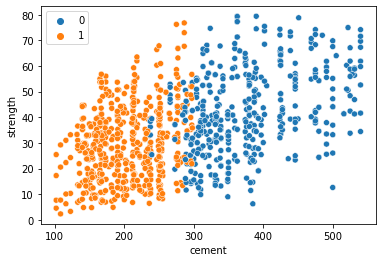

In [33]:
labels = KMeans(n_clusters = 2,random_state = 10)
cluster = labels.fit_predict(df.drop('strength',axis=1))
sns.scatterplot(x = df['cement'],y = df['strength'],hue = cluster)

In [42]:
def clustering(x,t_col,cluster):
    column = list(set(list(x.columns)) - set(x[t_col]))
    r = int(len(column)/2)
    if(r%2==0):
        r=r
    else:
        r+=1
    f,ax = plt.subplots(r,2,figsize=(20,18))
    a=0
    for row in range(r):
        for col in range(2):
            if(a!=len(column)):
                ax[row][col].scatter(x[t_col],x[column[a]],c=cluster)
                ax[row][col].set_xlabel(t_col)               
                ax[row][col].set_ylabel(column[a])               
                a+=1

In [43]:
X = df.drop('strength',axis=1)

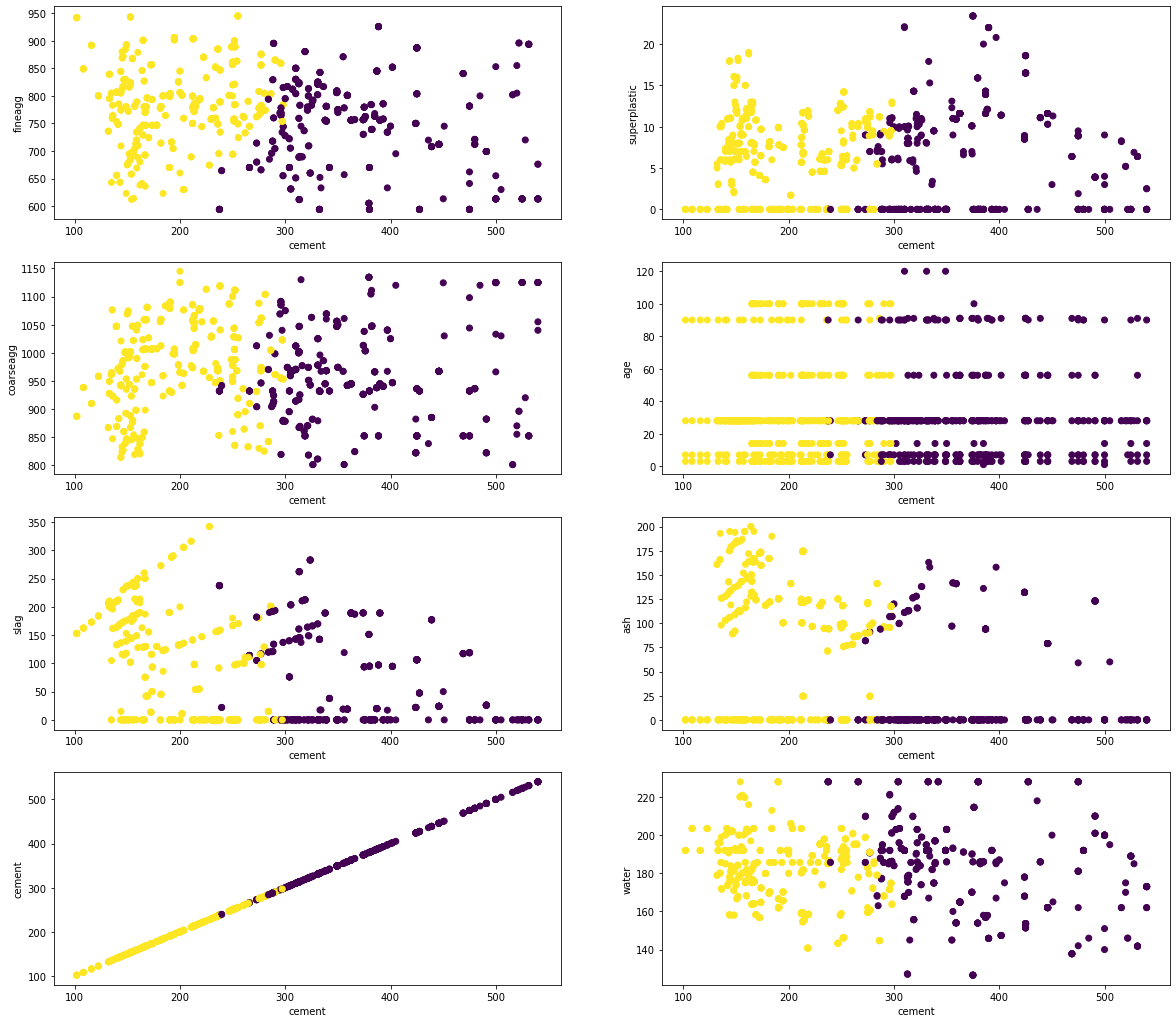

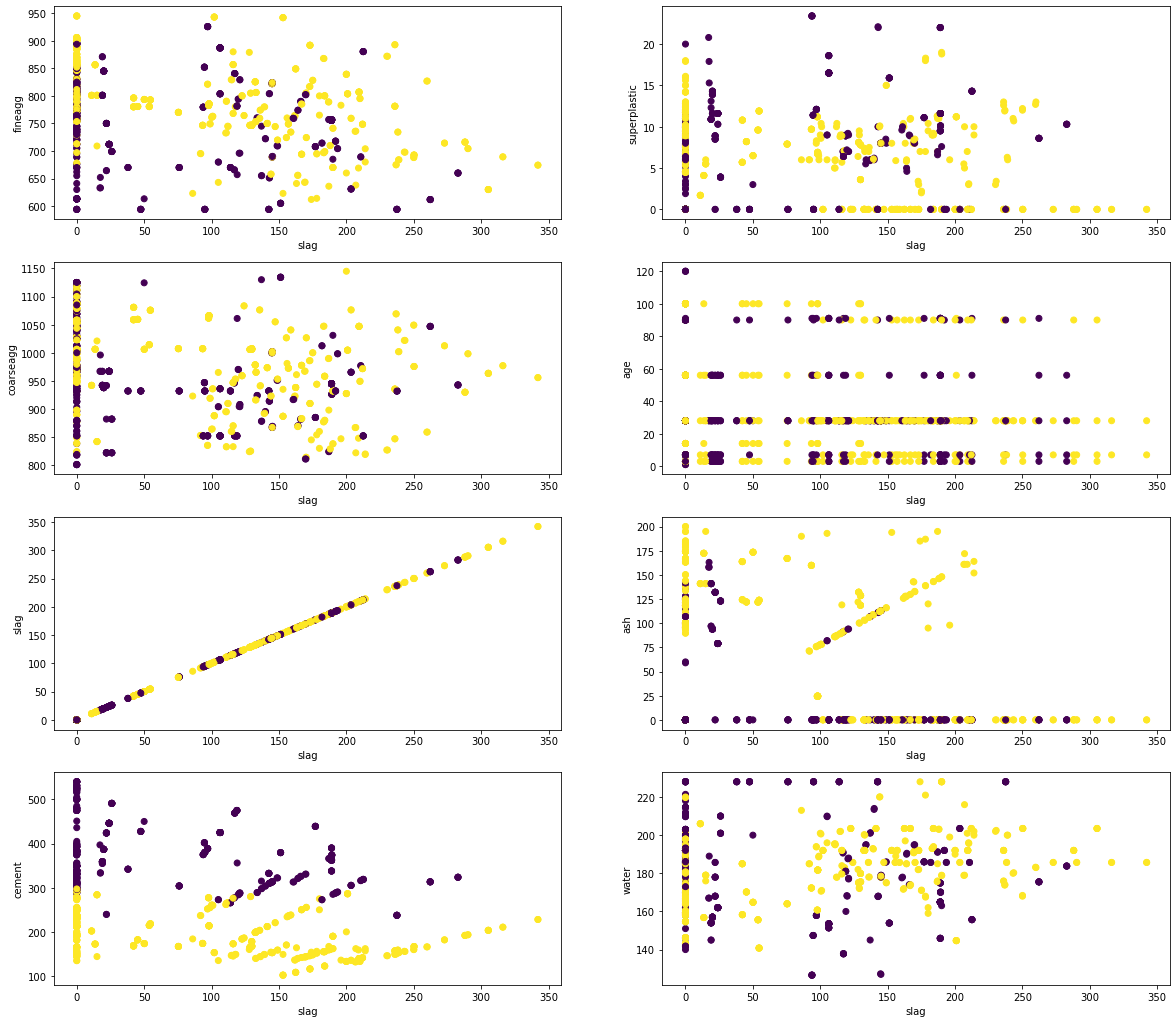

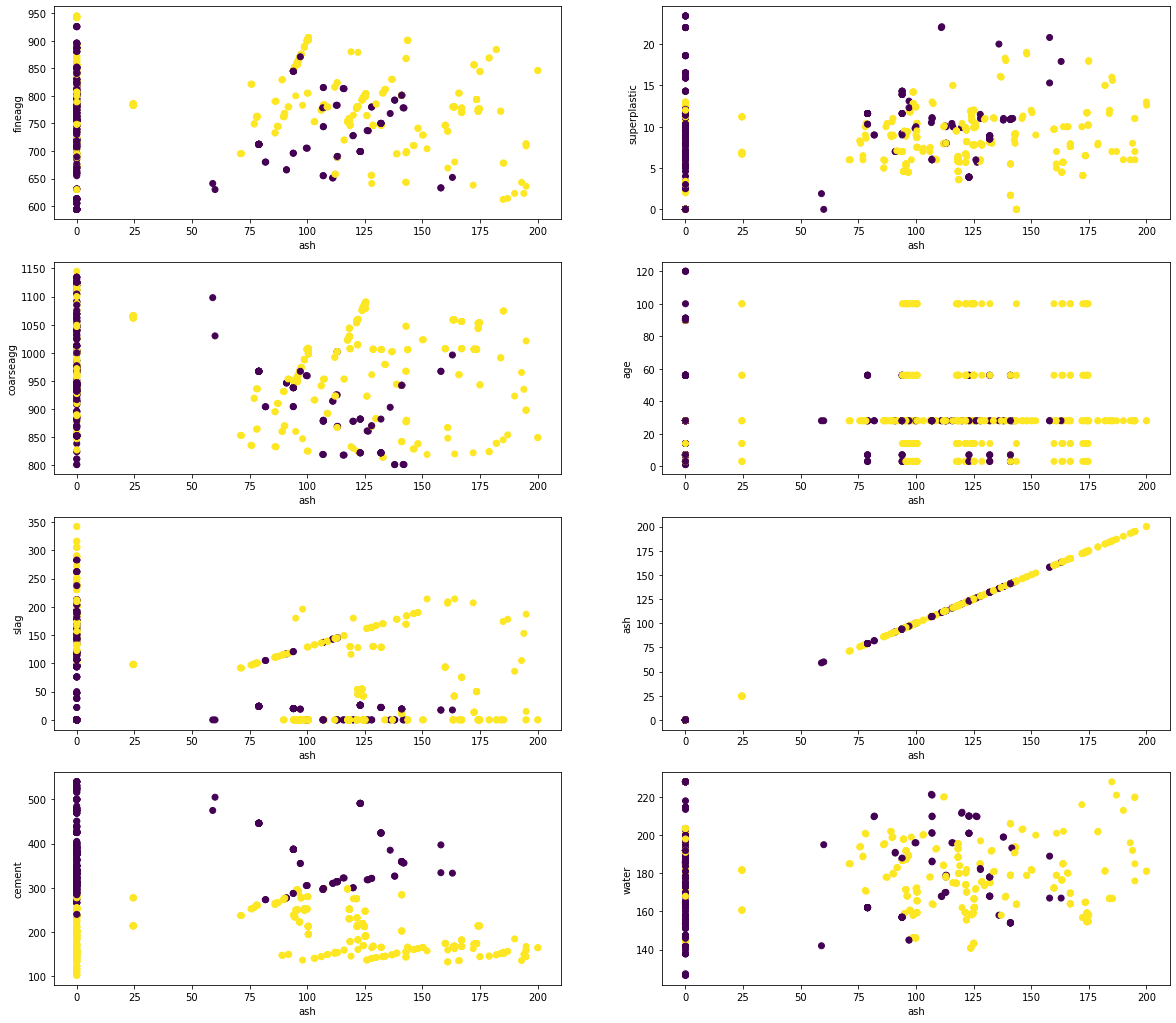

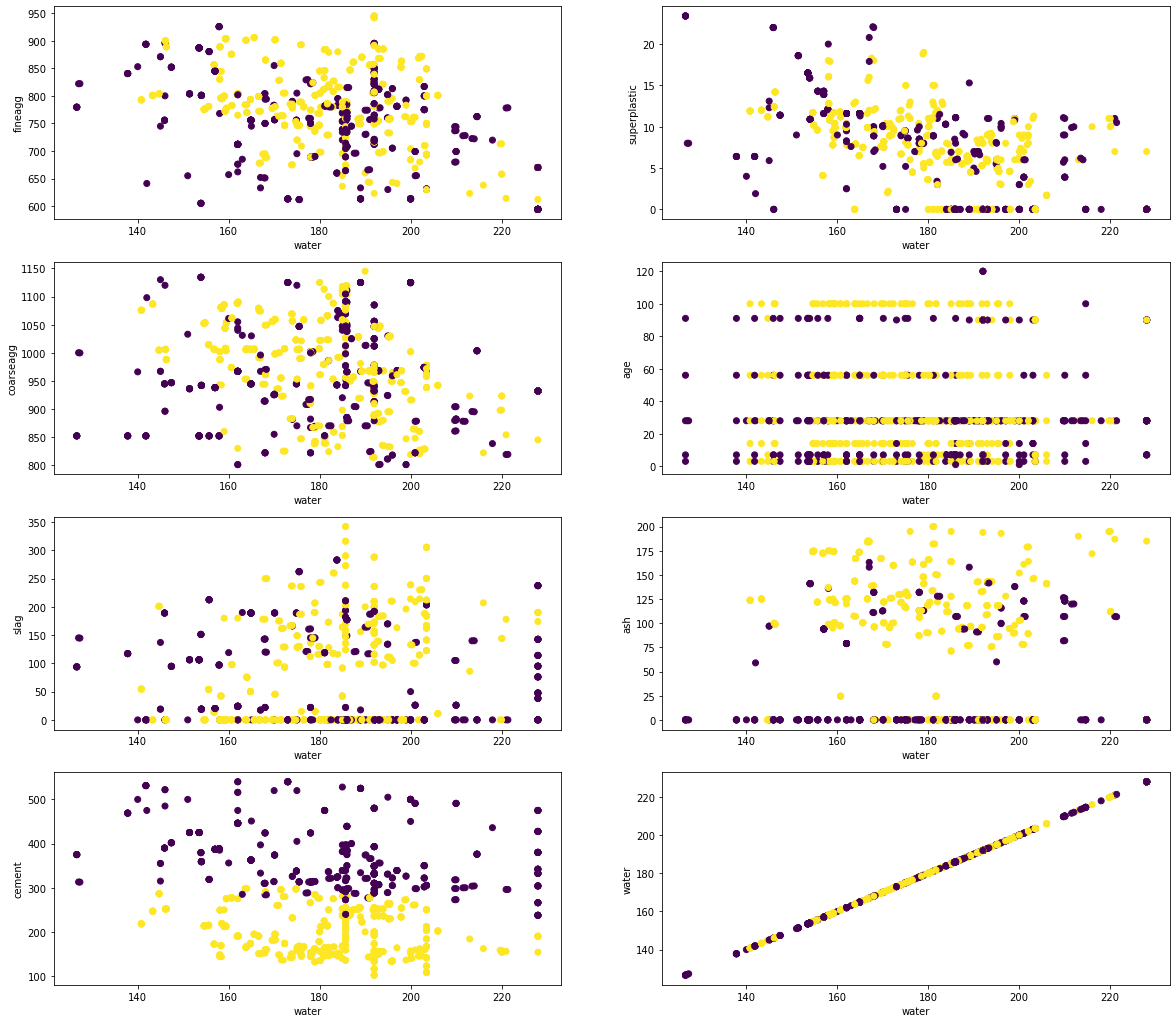

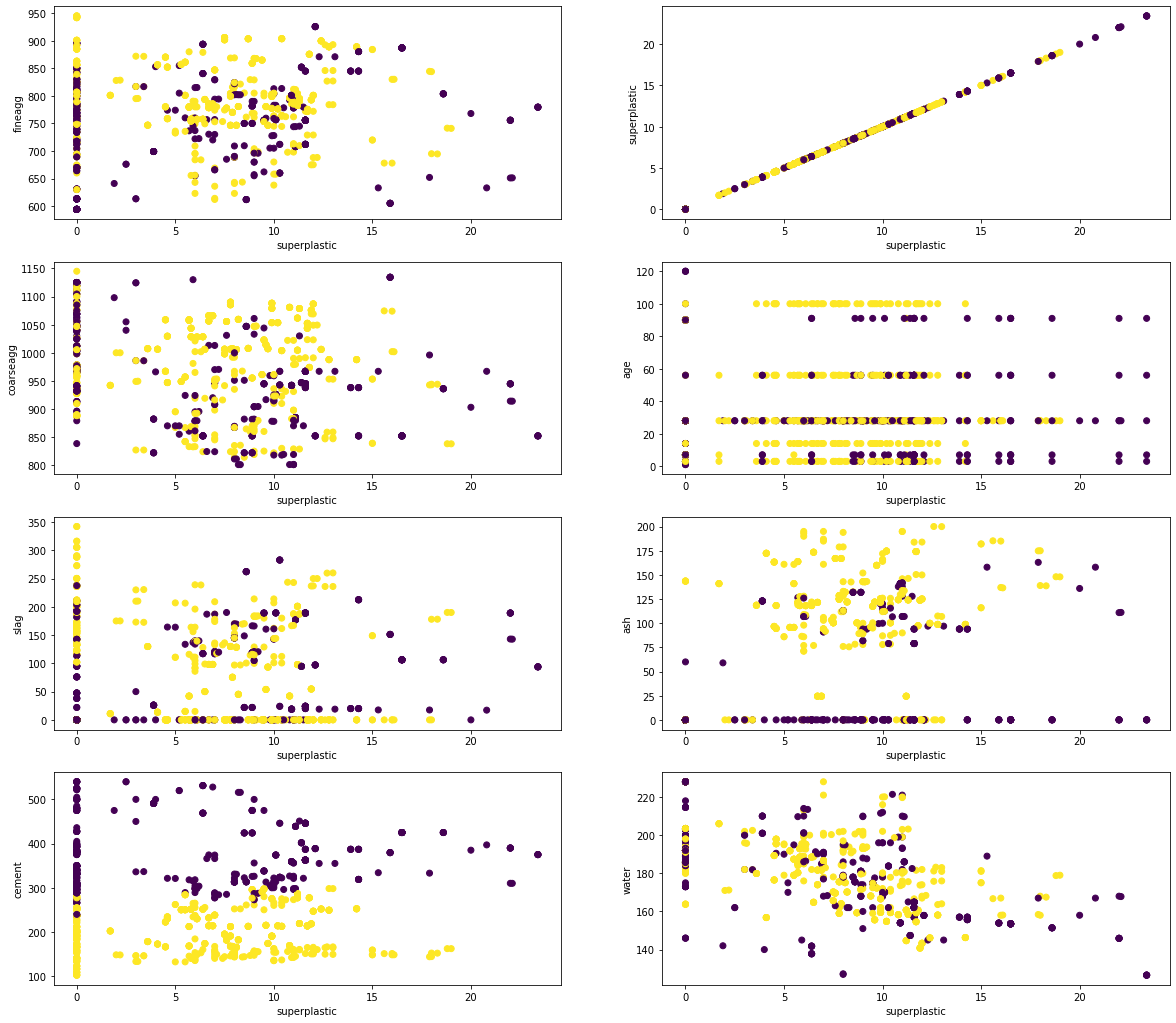

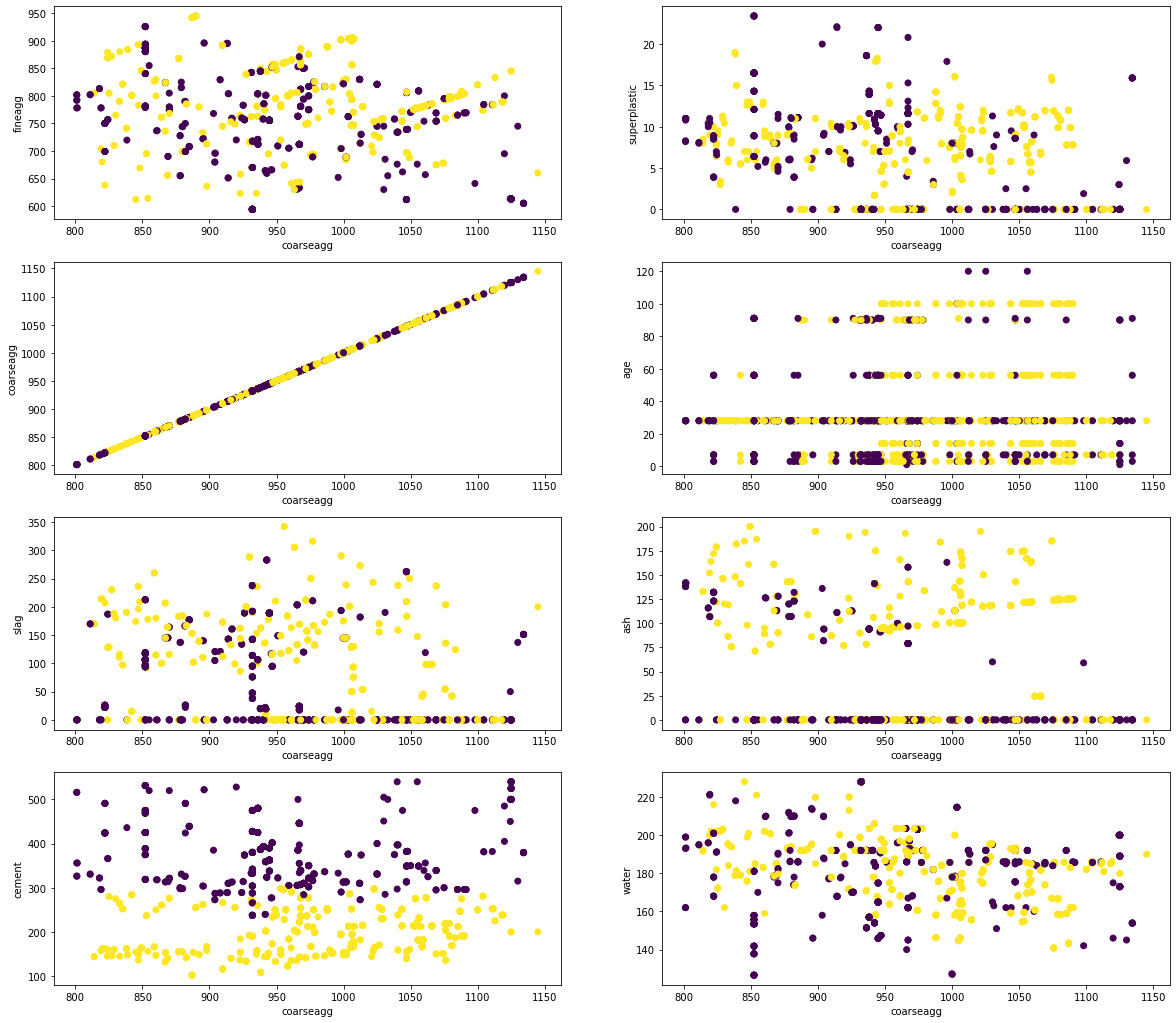

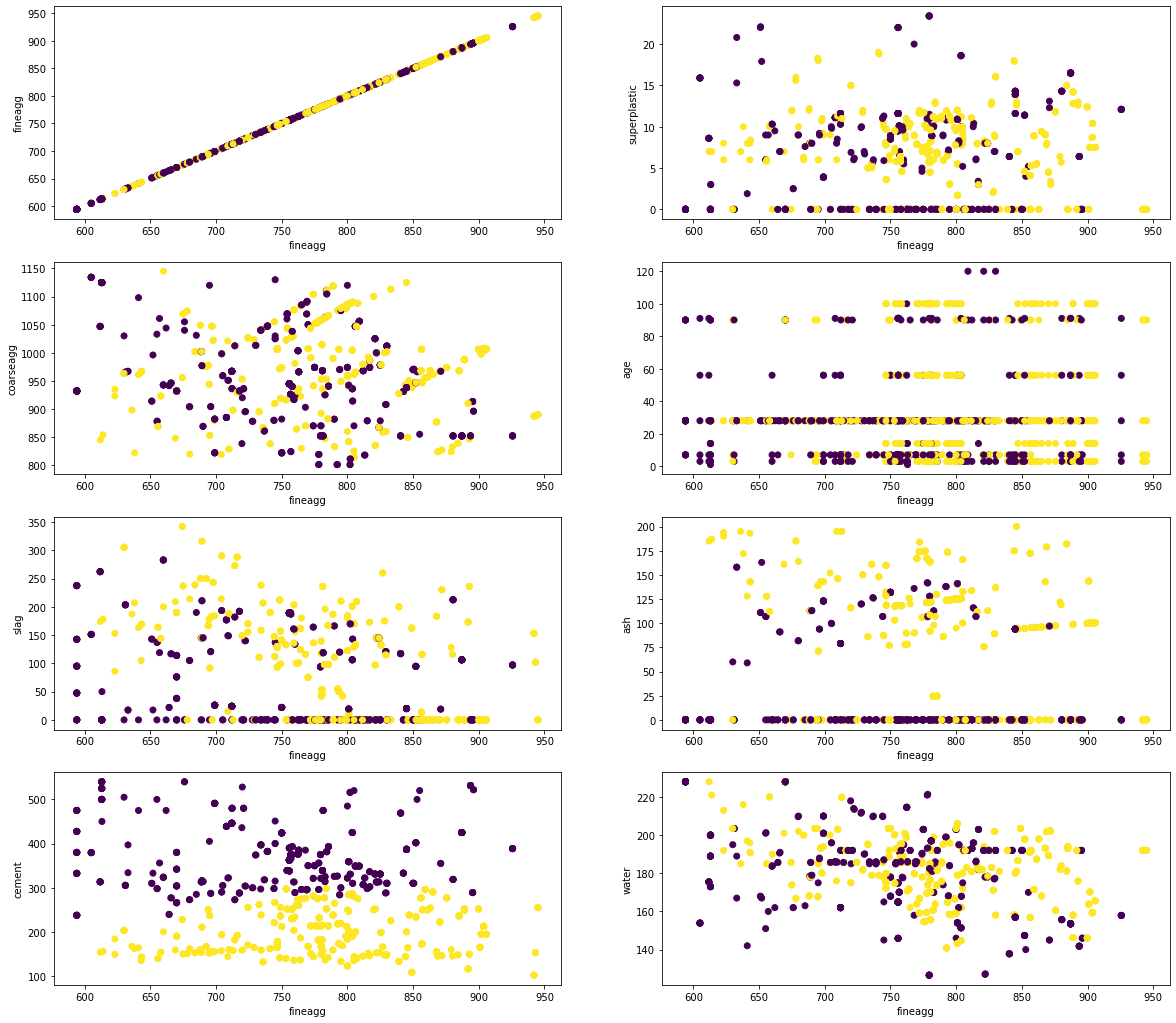

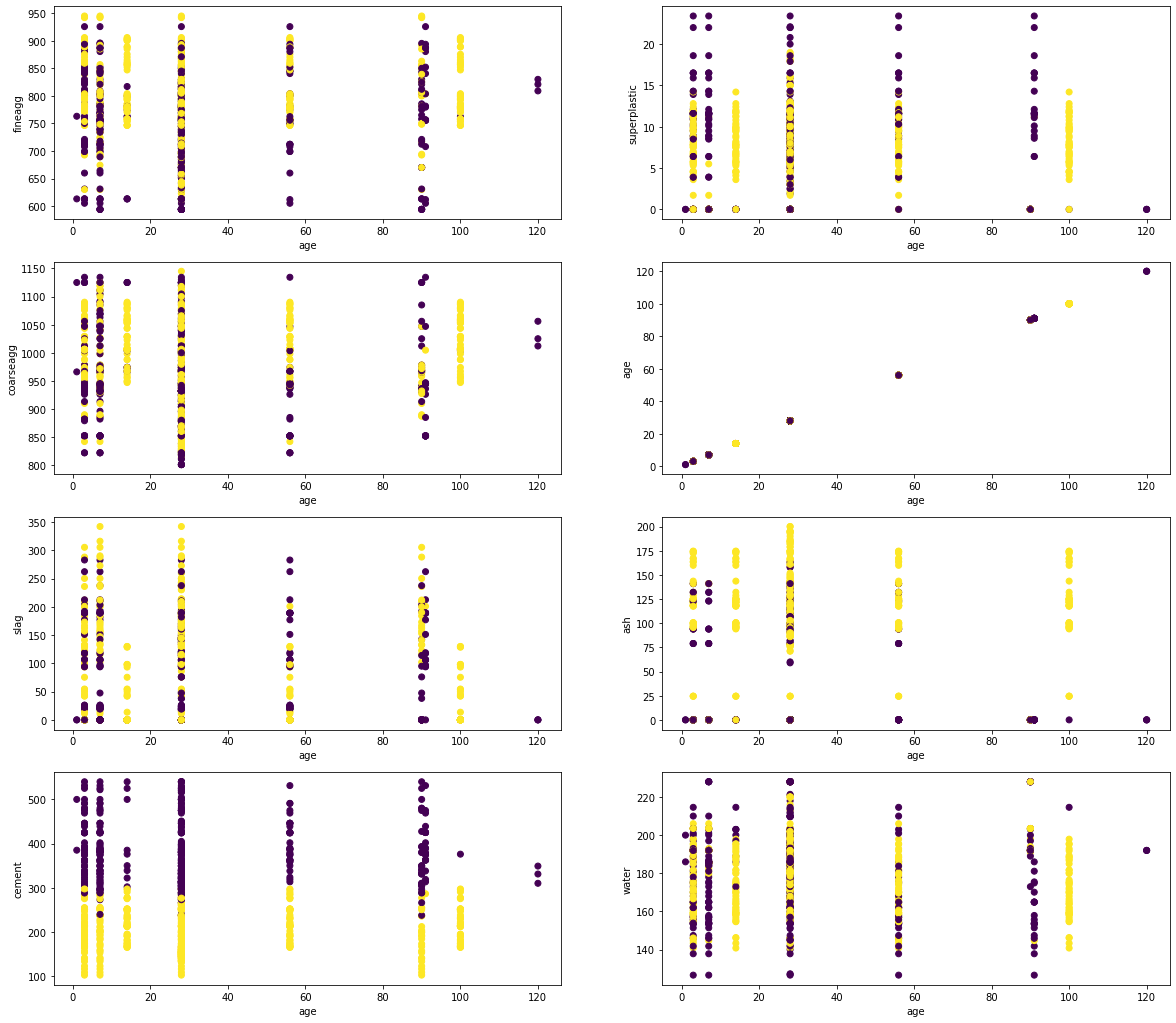

In [44]:
for col in X.columns:
    clustering(X,col,cluster)

### Analysis
    - Cement is forming clusters with all features

In [48]:
new_df = df.join(pd.DataFrame(cluster,columns=['clusters']),how='left')
new_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1


In [49]:
temp_df = new_df.groupby('clusters')['cement'].agg(['mean','median'])
temp_df.head()

,mean,median
clusters,,
0,374.104017,362.6
1,202.247217,200.0


In [50]:
cluster_df = new_df.merge(temp_df,on= 'clusters',how='left')
cluster_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1,202.247217,200.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1,202.247217,200.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1,202.247217,200.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0,374.104017,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1,202.247217,200.0


In [51]:
X = cluster_df.drop(['strength','clusters'],axis=1)
y = cluster_df['strength']

In [52]:
multiple_models(cluster_df,'strength')

,Model_Name,R2 Score,RMSE
0,XGBoost regressor,0.863192,5.929739
1,Random Forest regressor,0.856295,6.077374
2,Gradient Boost regressor,0.825353,6.699782
3,Decision Tree regressor,0.782503,7.476643
4,Adaboost regressor,0.749446,8.024738
5,K Neighbors regressor,0.735061,8.251873
6,Support Vector regressor,0.707881,8.664832
7,Linear regression,0.677259,9.107669
8,Ridge regression,0.677174,9.108865
9,Lasso regression,0.658662,9.366386


In [53]:
kfold_cv(cluster_df,'strength')

,Model Name,R2 Score,Score Std Deviation
0,XGBRegressor,0.901949,0.042320
1,RandomForestRegressor,0.887202,0.036642
2,GradientBoostingRegressor,0.874930,0.046414
3,DecisionTreeRegressor,0.828691,0.048280
4,AdaBoostRegressor,0.737399,0.039389
5,Ridge,0.686680,0.062293
6,LinearRegression,0.686651,0.062276
7,Lasso,0.686443,0.062370
8,KNeighborsRegressor,0.668523,0.087232
9,SVR,0.237486,0.044526


In [54]:
CV_post_hpt(X,y)

,model names,R2 Mean,R2 Std
0,XGB Regressor,0.902520,0.041962
1,Random Forest Regressor,0.890568,0.034013
2,Gradient Boosting Regressor,0.874913,0.046301
3,Decision Tree Regressor,0.828008,0.056206
4,AdaBoost Regressor,0.738206,0.039297
5,Ridge,0.686680,0.062293
6,Lasso,0.686680,0.062293
7,Linear Regression,0.686678,0.062279
8,KNeighbors Regressor,0.668523,0.087232
9,SVR,0.245706,0.044065


## Feature importance using XGBoost

In [55]:
X_train,X_test,y_train,y_test = train_and_test_split(cluster_df.drop('clusters',axis=1),'strength')

In [56]:
xgb = XGBRegressor()

In [57]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

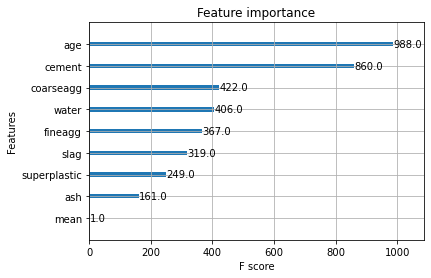

In [60]:
xgboost.plot_importance(xgb)

In [73]:
f_df = cluster_df[['age','cement','coarseagg','water','fineagg','slag','strength']]
f_df.head()

,age,cement,coarseagg,water,fineagg,slag,strength
0,28,141.3,971.8,203.5,748.5,212.0,29.89
1,14,168.9,1080.8,158.3,796.2,42.2,23.51
2,28,250.0,956.9,187.4,861.2,0.0,29.22
3,28,266.0,932.0,228.0,670.0,114.0,45.85
4,28,154.8,1047.4,193.3,696.7,183.4,18.29


In [74]:
CV_post_hpt(f_df.drop('strength',axis=1),f_df['strength'])

,model names,R2 Mean,R2 Std
0,XGB Regressor,0.900447,0.044839
1,Random Forest Regressor,0.887349,0.033219
2,Gradient Boosting Regressor,0.875494,0.046382
3,Decision Tree Regressor,0.828497,0.052228
4,AdaBoost Regressor,0.738559,0.038660
5,Ridge,0.679539,0.061858
6,Lasso,0.679539,0.061858
7,Linear Regression,0.679539,0.061858
8,KNeighbors Regressor,0.656356,0.087734
9,SVR,0.261459,0.037619


In [76]:
rfe = RFE(xgb)

In [77]:
rfe.fit(X_train,y_train)

RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False,
                           gamma=0, gpu_id=-1, importance_type=None,
                           interaction_constraints='',
                           learning_rate=0.300000012, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=nan,
                           monotone_constraints='()', n_estimators=100,
                           n_jobs=8, num_parallel_tree=1, predictor='auto',
                           random_state=0, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, subsample=1, tree_method='exact',
                           validate_parameters=1, verbosity=None))

In [78]:
rfe.support_

array([ True,  True, False,  True,  True, False, False,  True, False,
       False])

In [79]:
X.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'mean', 'median'],
      dtype='object')

In [82]:
rfe_df = cluster_df[['cement','slag','water','superplastic','age','strength']]
rfe_df.head()

,cement,slag,water,superplastic,age,strength
0,141.3,212.0,203.5,0.0,28,29.89
1,168.9,42.2,158.3,10.8,14,23.51
2,250.0,0.0,187.4,5.5,28,29.22
3,266.0,114.0,228.0,0.0,28,45.85
4,154.8,183.4,193.3,9.1,28,18.29


In [83]:
CV_post_hpt(rfe_df.drop('strength',1),rfe_df['strength'])

,model names,R2 Mean,R2 Std
0,XGB Regressor,0.901471,0.041001
1,Random Forest Regressor,0.889602,0.032989
2,Gradient Boosting Regressor,0.865501,0.045150
3,Decision Tree Regressor,0.825894,0.048595
4,KNeighbors Regressor,0.764982,0.063493
5,AdaBoost Regressor,0.744291,0.033599
6,Ridge,0.671701,0.059147
7,Lasso,0.671701,0.059148
8,Linear Regression,0.671701,0.059148
9,SVR,0.560489,0.042917


## Learning curve analysis

In [69]:
def generate_learning_curve(model_name,estimator,X,y,cv=10):
    train_size,train_score,test_score = learning_curve(estimator=estimator,X=X,y=y,cv=cv)
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='red')   
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.title('Learning curve for '+model_name)
    plt.legend(('Training_accuracy','Testing_accuracy'))

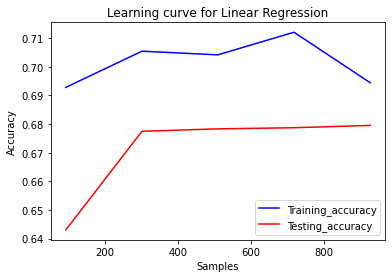

In [71]:
generate_learning_curve('Linear Regression',LinearRegression(),f_df.drop('strength',axis=1),f_df['strength'])

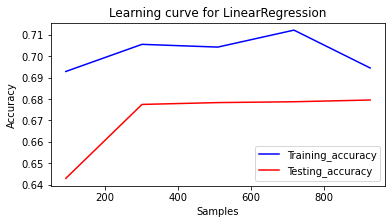

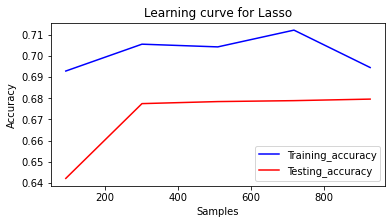

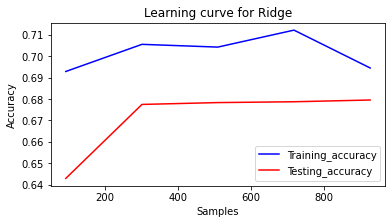

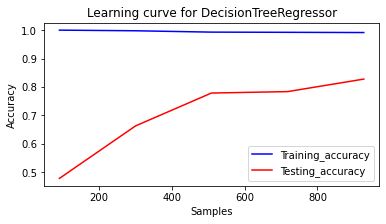

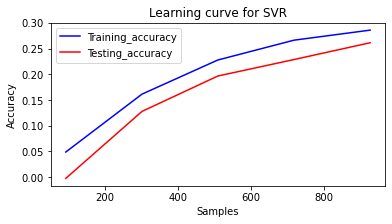

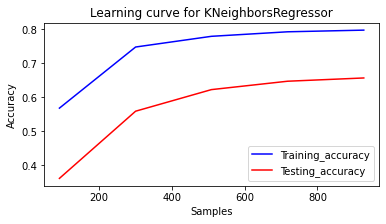

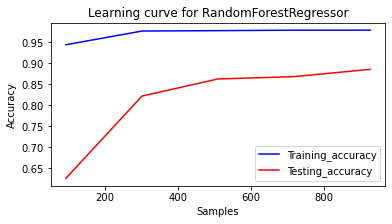

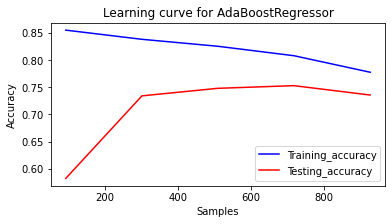

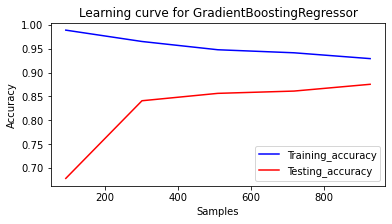

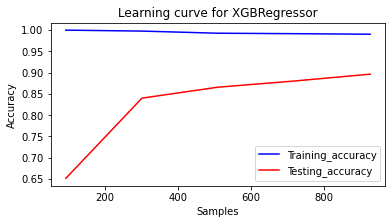

In [72]:
model_names = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),SVR(),KNeighborsRegressor(),
               RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
for a ,model in enumerate(model_names):
    fg = plt.figure(figsize=(6,3))
    ax = fg.add_subplot(5,2,a+1)
    generate_learning_curve(type(model_names[a]).__name__,model,f_df.drop('strength',1),f_df['strength'])